In [1]:
%matplotlib inline
from scipy.io import loadmat
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.cm as cmx
import pandas as pd
import numpy as np
import os
import seaborn as sns
import csv
import random

<h2> Process Single File</h3>

<h3>Make F0 raw csv files

In [2]:
# load the mat file
mat_dict = loadmat('/Users/robinson/Dropbox/anasynth/_data/Olivia2006/Olivia2006.e01.p02.i00.mat')

# get variables from dict
f0_raw = mat_dict['f0_raw']
f0_raw = f0_raw.reshape((f0_raw.shape[1],))
print(np.shape(f0_raw))

(3110,)


In [3]:
# strip leading and trailing zeros
f0_raw = np.trim_zeros(f0_raw, trim='fb')
print(f0_raw[:])
print(f0_raw.shape[0])

[239.76754761 239.76678467 239.77609253 ... 167.793396   167.77375793
 167.75679016]
2510


In [29]:
# quantise the values into a vocabulary of 10,000 increments

# create new array to hold rounded values
f0_raw_2dp = np.zeros(f0_raw.shape)
# round all values to 2dp, to get vocabulary of ~10000 given f0 min/max range of 300
np.around(f0_raw, decimals=2, out=f0_raw_2dp)
print(f0_raw_2dp)
# multiply by 100 to shift dp two places
f0_raw_2dp = f0_raw_2dp * 100
print(f0_raw_2dp)
# cast to int to ensure precise number representation in memory
f0_raw_2dp = f0_raw_2dp.astype(int)
print(f0_raw_2dp)

[239.77 239.77 239.78 ... 167.79 167.77 167.76]
[23977. 23977. 23978. ... 16779. 16777. 16776.]
[23977 23977 23978 ... 16779 16777 16776]


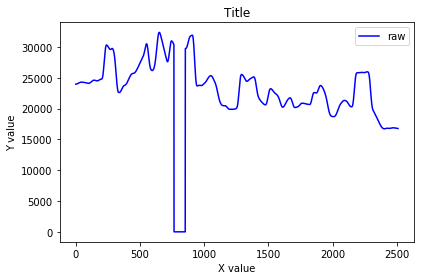

In [30]:
# plot 
fig = plt.figure()
plt.title('Title')
plt.xlabel('X value')
plt.ylabel('Y value')
# plt.xlim(-2.2, 2.2)
# plt.ylim(-1.65, 1.6)

plt.plot(range(f0_raw_2dp.shape[0]), f0_raw_2dp[:], color='b', label='raw')

plt.legend()
plt.tight_layout()
plt.show()
# fig.savefig('out.png')

In [32]:
# write out csv file of f0_raw values - specify format as %u for values to be written as int
np.savetxt('out.csv', f0_raw_2dp, delimiter=',', fmt='%u')

<h3> Make Single Source and Target Input Files</h3>

In [53]:
# path to input files directory - change between source/target
directory_path = '/Users/robinson/Dropbox/anasynth/_data/Olivia2006/f0_raw/target'
directory = os.fsencode(directory_path)
# output filename - change between source/target
filename_out = 'target.csv'

# open output file in 'out' subdirectory of input files directory
f = open(os.path.join(directory_path, 'out', filename_out), 'w')

# for each source file in source directory
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.csv'): 
        # build filepath
        filepath = os.path.join(directory_path, filename)
        # print(filepath)
        
        # load the file and extract vars
        f0_raw = np.loadtxt(filepath, dtype='int')
        # reshape to have two indices, the first being a constant so all values belong to the same 'row'
        f0_raw = f0_raw.reshape((1, f0_raw.shape[0]))
        # print(f0_raw.shape)
 
        # append it to output file as a new row, with space delimiter between elements
        np.savetxt(f, f0_raw, delimiter=' ', fmt='%u')
        
        continue
    else:
        continue

# close the output file
f.close()

print('done')

done


<h2> Process Multiple Files</h3>

<h3>Make F0 raw csv files

In [2]:
# set number of decimal places
dec = 0

# path to input files directory
directory_path_root = '/Users/robinson/Dropbox/anasynth/_data/emoVC/Olivia2006'
directory = os.fsencode(directory_path_root)
# path to output files directory
directory_path_f0raw = '/Users/robinson/Dropbox/anasynth/_data/emoVC/Olivia2006/f0_raw'
if not os.path.exists(directory_path_f0raw):
    os.mkdir(directory_path_f0raw)

# for each mat file in directory (each mat file has one sequence of f0 raw values in it)
for file in os.listdir(directory):
    filename = os.fsdecode(file)
    if filename.endswith('.mat'): 
        # build filepath (should use file var here really)
        filepath = os.path.join(directory_path_root, filename)
        # print(filepath)
        
        # load the file and extract f0 raw var
        mat_dict = loadmat(filepath)
        f0_raw = mat_dict['f0_raw']
        f0_raw = f0_raw.reshape((f0_raw.shape[1],))
        
        # strip leading and trailing zeros
        f0_raw = np.trim_zeros(f0_raw, trim='fb')
        
        # create new array to hold rounded values
        f0_raw_dec = np.zeros(f0_raw.shape)
        # round all values to dec dp
        np.around(f0_raw, decimals=dec, out=f0_raw_dec)
        # multiply by 10^dec to shift dp dec places to the right
        f0_raw_dec = f0_raw_dec * (10**dec)
        # cast to int to ensure precise number representation in memory
        f0_raw_dec = f0_raw_dec.astype(int)
        
        # write out csv file of f0_raw values - specify format as %u for values to be written as int
        filename_noext, _ = os.path.splitext(filename)
        np.savetxt(os.path.join(directory_path_f0raw, filename_noext + '.csv'), f0_raw_dec, delimiter=',', fmt='%u')
        
        continue
    else:
        continue
        
print('done')

done


<h3> Make Combo Source and Target Input Files</h3>

In [3]:
# the above code makes output files with one row per wav file
# we can't use these as-is, as we need to read the lines in as pairs, so source and target must have equal num of rows
# next step is to pair the files using the phrase and intensities in the filenames

# source: 10 phrases of i00 intensity across e01 to e08 - each phrase is said 8 times, neutrally
# target: 10 phrases of i01-i05 intensity for e02 - each phrase is said 5 times, expressively (5 times)
# so for each utterance (8 of) of each 'p' source phrase (10 of), copy it 5 times, matched with i01-i05 of 'p' target
# P(10) > E(8) > I(5)

# total number of segments e.g. 6 segments + 5 overlaps = 11 total segments for source and target
num_segments = 11

# build paths and open output files
# path to input files directories
# input_directory_path = '/Users/robinson/Dropbox/anasynth/_data/emoVC/Olivia2006/f0_raw'
input_directory_path = directory_path_f0raw # from previous block
output_directory = os.path.join(input_directory_path, 'out')
if not os.path.exists(output_directory):
    os.mkdir(output_directory)
# output filenames
filename_source = 'source.txt'
filename_target = 'target.txt'
filename_log = 'log.txt'
# open output files in subdirectory of input files directory (must create manually)
fs = open(os.path.join(output_directory, filename_source), 'w')
ft = open(os.path.join(output_directory, filename_target), 'w')
fo = open(os.path.join(output_directory, filename_log), 'w')

# define filename components
# Olivia2006.e02.p01.i01.csv
input_file_root = 'Olivia2006'
input_file_extension = '.csv'
# define phrase range
phrase_from = 1
phrase_to = 10
# define source and target emotion ranges
source_emotion_from = 1
source_emotion_to = 8
target_emotion_from = 2
target_emotion_to = 2
# define source and target intensity ranges
source_intensity_from = 0
source_intensity_to = 0
target_intensity_from = 1
target_intensity_to = 5

# set source_len_max initial values
source_len_max = 0
source_seg_len_max = 0
target_len_max = 0
target_seg_len_max = 0


# for each phrase 1-10
#     for each source emotion 1-8
#         for each source intensity 0
#             for each target emotion 2
#                 for each target intensity 1-5
#                     write source phrase p-e_s-i_s to source output
#                     write target phrase p-e_t-i_t to target output
# for each phrase
for p in range(phrase_from, phrase_to + 1):
    # for each source emotion
    for e_s in range(source_emotion_from, source_emotion_to + 1):
        # for each source intensity
        for i_s in range(source_intensity_from, source_intensity_to + 1):
            # for each target emotion
            for e_t in range(target_emotion_from, target_emotion_to + 1):
                # for each target intensity
                for i_t in range(target_intensity_from, target_intensity_to + 1):
                    
                    # build the source file path
                    source_file_name = ''.join([input_file_root, 
                                                '.e', format(e_s, '02d'),
                                                '.p', format(p, '02d'),
                                                '.i', format(i_s, '02d'),
                                                input_file_extension])   
                    source_file_path = os.path.join(input_directory_path, source_file_name)
                    # load the source file and extract vars
                    source_f0_raw = np.loadtxt(source_file_path, dtype='int')
#                     print(source_f0_raw.shape)
                    
                    # reshape to have two indices, the first being a constant so all values belong to the same 'row'
                    source_f0_raw = source_f0_raw.reshape((1, source_f0_raw.shape[0]))                    
                    
                    # determine source segment/overlap segment length
                    source_seg_len = source_f0_raw.shape[1] // num_segments
                    # extract (num_segments + num_overlaps) sequences of source_seg_len length every source_seg_len/2
                    for i in range(num_segments):
                        start = i * (source_seg_len//2)
                        end = start + source_seg_len
                        source_f0_raw_seg = source_f0_raw[0, start:end].reshape((1, source_f0_raw[0, start:end].shape[0]))
                        # append it to output file as a new row, with space delimiter between elements, format unsigned int
                        np.savetxt(fs, source_f0_raw_seg, delimiter=' ', fmt='%u')

                    
                    # build the target file path
                    target_file_name = ''.join([input_file_root, 
                                                '.e', format(e_t, '02d'),
                                                '.p', format(p, '02d'),
                                                '.i', format(i_t, '02d'),
                                                input_file_extension])
                    target_file_path = os.path.join(input_directory_path, target_file_name)
                    # load the target file and extract vars
                    target_f0_raw = np.loadtxt(target_file_path, dtype='int') 
                    # reshape to have two indices, the first being a constant so all values belong to the same 'row'
                    target_f0_raw = target_f0_raw.reshape((1, target_f0_raw.shape[0]))
                    
                    # determine target segment/overlap segment length ()
                    target_seg_len = target_f0_raw.shape[1] // num_segments
                    # extract (num_segments + num_overlaps) sequences of target_seg_len length every target_seg_len/2
                    for i in range(num_segments):
                        start = i * (target_seg_len//2)
                        end = start + target_seg_len
                        target_f0_raw_seg = target_f0_raw[0, start:end].reshape((1, target_f0_raw[0, start:end].shape[0]))
                        # append it to output file as a new row, with space delimiter between elements, format unsigned int
                        np.savetxt(ft, target_f0_raw_seg, delimiter=' ', fmt='%u')

                    # write input and output file pair to log file
                    logstring = source_file_path + '   ' + target_file_path
                    print(logstring, file=fo)
                    
                    # update max lengths if larger than stored values
                    if source_f0_raw.shape[1] > source_len_max:
                        source_len_max = source_f0_raw.shape[1]
                    if source_seg_len > source_seg_len_max:
                        source_seg_len_max = source_seg_len
                    if target_f0_raw.shape[1] > target_len_max:
                        target_len_max = target_f0_raw.shape[1]
                    if target_seg_len > target_seg_len_max:
                        target_seg_len_max = target_seg_len
                        
            
# close the output files
fs.close()
ft.close()

print('source_len_max = ' + str(source_len_max))
print('source_seg_len_max = ' + str(source_seg_len_max))
print('target_len_max = ' + str(target_len_max))
print('target_seg_len_max = ' + str(target_seg_len_max))
print('done')

source_len_max = 1091
source_seg_len_max = 99
target_len_max = 921
target_seg_len_max = 83
done


In [4]:
# shuffle the source/target pairs and split them out into train/val/test files

# set ratios for train/val/test split e.g. 0.6, 0.2, 0.2
train_split = 0.6
val_split = 0.2
test_split = 0.2

# get line counts of files (source and target will be the same, so just need to check one of them)
with open(os.path.join(output_directory, filename_source)) as f:
    f_lines = sum(1 for _ in f)
    # set index values for train, val and test
    train_lines = int(f_lines // (1 / train_split))
    val_lines = int(f_lines // (1 / val_split))
    test_lines = f_lines - train_lines - val_lines # whatever is left
    
# open source and target input files to read from
fs = open(os.path.join(output_directory, filename_source), 'r')
ft = open(os.path.join(output_directory, filename_target), 'r')

# read the source and target input files line by line, stripping all whitespace and empty lines
source_data = fs.read().strip().split('\n')
target_data = ft.read().strip().split('\n')
# make a list of tuples, each holding a pair of source and target strings
merged_data = list(zip(source_data, target_data))
# shuffle the tuples (preserving the pairing) to ensure a good mix of p/e/i in each set
random.shuffle(merged_data)

# seperate the tuples into two lists of source and target lines
train_data_source = [x[0] for x in merged_data[:train_lines]]
train_data_target = [x[1] for x in merged_data[:train_lines]]
val_data_source = [x[0] for x in merged_data[train_lines:(train_lines+val_lines)]]
val_data_target = [x[1] for x in merged_data[train_lines:(train_lines+val_lines)]]
test_data_source = [x[0] for x in merged_data[(train_lines+val_lines):]]
test_data_target = [x[1] for x in merged_data[(train_lines+val_lines):]]

# make train, test, dev, model directories
train_dir = os.path.join(output_directory, 'train')
dev_dir = os.path.join(output_directory, 'dev')
test_dir = os.path.join(output_directory, 'test')
model_dir = os.path.join(output_directory, 'model')
if not os.path.exists(train_dir):
    os.mkdir(train_dir)
if not os.path.exists(dev_dir):
    os.mkdir(dev_dir)
if not os.path.exists(test_dir):
    os.mkdir(test_dir)
if not os.path.exists(model_dir):
    os.mkdir(model_dir)
    
# open output files to write to
f_train_source = open(os.path.join(train_dir, 'train_source.txt'), 'w')
f_train_target = open(os.path.join(train_dir, 'train_target.txt'), 'w')
f_val_source = open(os.path.join(dev_dir, 'val_source.txt'), 'w')
f_val_target = open(os.path.join(dev_dir, 'val_target.txt'), 'w')
f_test_source = open(os.path.join(test_dir, 'test_source.txt'), 'w')
f_test_target = open(os.path.join(test_dir, 'test_target.txt'), 'w')

# write each of the lists to the opened files
[print(line, file=f_train_source) for line in train_data_source]
[print(line, file=f_train_target) for line in train_data_target]
[print(line, file=f_val_source) for line in val_data_source]
[print(line, file=f_val_target) for line in val_data_target]
[print(line, file=f_test_source) for line in test_data_source]
[print(line, file=f_test_target) for line in test_data_target]

# close the input source and target files
fs.close()
ft.close()

print('fs_lines = ' + str(f_lines))
print('train_lines = ' + str(train_lines))
print('val_lines = ' + str(val_lines))
print('test_lines = ' + str(test_lines))
print('done')

fs_lines = 4400
train_lines = 2639
val_lines = 880
test_lines = 881
done


<h3> Make Vocabulary Inputs

In [5]:
for file in [filename_source, filename_target]:

    # open output files in subdirectory of input files directory (must create manually)
    fs = open(os.path.join(output_directory, file), 'r')

    # read the source and target input files line by line, stripping all whitespace and empty lines
    source_data = fs.read().strip().split('\n')

    # set min and max initial values
    source_data_min = float('Inf')
    source_data_max = 0.0

    for i in range(len(source_data)):
        source_array = np.array([int(x) for x in source_data[i].split(' ')])
        if source_array.max() > source_data_max:
            source_data_max = source_array.max()
        if np.min(source_array[np.nonzero(source_array)]) < source_data_min:
            source_data_min = np.min(source_array[np.nonzero(source_array)])

    # print range of integers from min to max found in files
    range_size = (source_data_max - source_data_min) + 1
    samples = np.linspace(source_data_min, source_data_max, num=range_size, endpoint=True, retstep=False, dtype=int)
    print(samples)

    # save vocabulary input files to train_dir
    filename_noext, _ = os.path.splitext(file)
    np.savetxt(os.path.join(train_dir, filename_noext + '_vocab_input.txt'), samples, delimiter=' ', fmt='%u')

    
# delete the input source and target files
# os.remove(os.path.join(output_directory, filename_source))
# os.remove(os.path.join(output_directory, filename_target))

# now run the vocabulary script to make the proper vocab files

[ 50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67
  68  69  70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103
 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121
 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139
 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157
 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175
 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193
 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211
 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229
 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247
 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265
 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281 282 283
 284 285 286 287 288 289 290 291 292 293 294 295 29